<a href="https://colab.research.google.com/github/jeovafarias/SAR-Roughness-Estimation-Neural-Nets/blob/main/Samples_SAR_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [56]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import scipy.stats as stats
import time
%matplotlib inline

import os
import sys
import warnings
warnings.filterwarnings("ignore")
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

INF = 999

root_path = '/content/drive/MyDrive/cs thesis - Li Fan/results'
os.chdir(root_path)
data_path = root_path+'/mse_new/Gi0/L1'
dirs = os.listdir(data_path)

def sample_gi0(alpha,gamma,L,sample_size):
  """
  Sample from gi0 distribution: Z=X/Y'
  Inputs: alpha<0, gamma>0, L=1,3,8;
  Outputs: random samples of the given sample size
  Using the SAR textbook Gamma notations:
  X follows Gamma(1,L);
  Y' follows Gamma(-alpha,gamma)
  """
  xx = stats.gamma.rvs(a=L, scale=1/L, size=sample_size)
  yy = stats.gamma.rvs(a=gamma, scale=-alpha/gamma, size=sample_size)
  zz = xx/yy
  return zz


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
We are using the following device for learning: cuda


In [57]:
!nvidia-smi

Wed May 31 17:15:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |    821MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [58]:
!nvidia-smi -queries=memory.total
!lscpu |grep 'Model name'
!free -h --si | awk  '/Mem:/{print $2}'

Invalid combination of input arguments. Please run 'nvidia-smi -h' for help.

Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
26G


## Parameters

In [59]:
L = 8
ds_size = 1000
batch_size = 32
n_epochs = 300
alphas = np.linspace(-15, -1.5, num=10)
sample_sizes = np.power(10, np.arange(2, 5))
monte_carlo_trials = 1000

## Generate Data

In [60]:
def compute_log_moment(sample, order):
    return np.mean(np.power(np.log(sample),order))

def generate_synthetic_dataset(num_moments, ds_size, alphas, L, sample_sizes):
  x_train = np.zeros((ds_size, num_moments))
  y_train = np.zeros((ds_size, 2))
  for i in range(ds_size):
    alpha = np.random.choice(alphas)
    gamma = -alpha - 1    
    sample_size = np.random.choice(sample_sizes)

    sample = sample_gi0(alpha, gamma, L, sample_size)
    x_train[i] = [compute_log_moment(sample, j) for j in range(1, num_moments + 1)]
    y_train[i] = [alpha, gamma]

  return x_train, y_train

# Network / Dataset Settings and Training

In [61]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    
    batch_loss = loss_fn(model(x), y)  # Compute loss
    batch_loss.backward()              # Compute gradients
    opt.step()                         # Make a GD step
    opt.zero_grad()                    # Flush memory  

    return batch_loss.detach().cpu().numpy()

@torch.no_grad()
def mse_error_neural_network(x, y, model):
    model.eval()
    y_hat = model(torch.Tensor(x).to(device)).detach().cpu().numpy()
    y_true = y
    if y_hat[0][0]>0 or y_hat[0][0]<-15:
      return INF
    else:
      return np.linalg.norm(y_true[0] - y_hat[0])

In [62]:
class NeuralNet(nn.Module):
    def __init__(self, num_moments = 2):
        super().__init__()  
        self.l1 = nn.Linear(num_moments, 8)
        self.l2 = nn.Linear(8, 4)
        self.l3 = nn.Linear(4, 2)
        self.AC1 = nn.Tanh() 
        self.AC2 = nn.Tanh()
    def forward(self, x):
        x = self.l1(x)
        x = self.AC1(x)
        x = self.l2(x)
        x = self.AC2(x)
        x = self.l3(x)
        return x

loss_fn = nn.MSELoss(reduction='mean')

In [63]:
class SampleDataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = torch.Tensor(x), torch.Tensor(y)
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

## Train Network for 2 log-moments

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
Running epoch 1 of 300
Running epoch 31 of 300
Running epoch 61 of 300
Running epoch 91 of 300
Running epoch 121 of 300
Running epoch 151 of 300
Running epoch 181 of 300
Running epoch 211 of 300
Running epoch 241 of 300
Running epoch 271 of 300
Time taken: 25.29s, Loss: 0.08s.


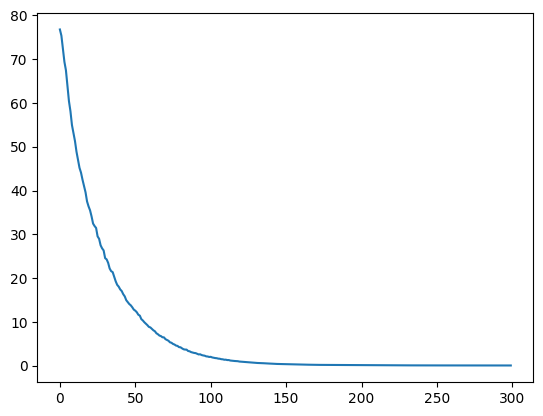

In [64]:
%time
num_moments = 2
x_train, y_train = generate_synthetic_dataset(num_moments, ds_size, alphas, L, sample_sizes)

train_dataset = SampleDataset(x_train, y_train) 
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)

model_2mom = NeuralNet(num_moments).to(device)
optimizer = Adam(model_2mom.parameters(), lr=1e-3)

start_time = time.time()
losses, errors = [], []
for epoch in range(n_epochs):
    if epoch % 30 == 0:
      print(f"Running epoch {epoch + 1} of {n_epochs}")
    
    epoch_losses = []
    for batch in train_dl:
        x, y = batch
        batch_loss = train_batch(x, y, model_2mom, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    losses.append(np.mean(epoch_losses))

print("Time taken: %.2fs, Loss: %.2fs." % (time.time() - start_time, losses[-1]))
plt.plot(losses)

## Train Network for 4 log-moments

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
Running epoch 1 of 300
Running epoch 31 of 300
Running epoch 61 of 300
Running epoch 91 of 300
Running epoch 121 of 300
Running epoch 151 of 300
Running epoch 181 of 300
Running epoch 211 of 300
Running epoch 241 of 300
Running epoch 271 of 300
Time taken: 23.36s, Loss: 0.10s.


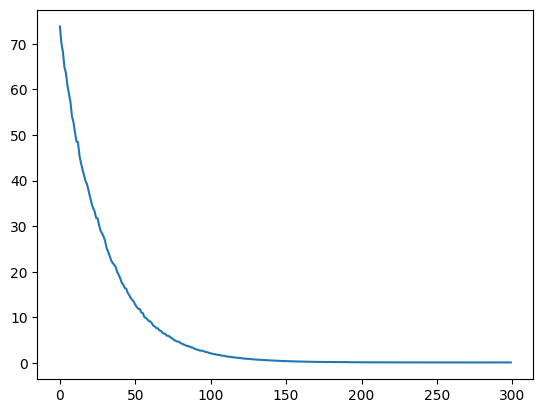

In [65]:
%time
num_moments = 4
x_train, y_train = generate_synthetic_dataset(num_moments, ds_size, alphas, L, sample_sizes)

train_dataset = SampleDataset(x_train, y_train) 
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)

model_4mom = NeuralNet(num_moments).to(device)
optimizer = Adam(model_4mom.parameters(), lr=1e-3)

start_time = time.time()
losses, errors = [], []
for epoch in range(n_epochs):
    if epoch % 30 == 0:
      print(f"Running epoch {epoch + 1} of {n_epochs}")
    
    epoch_losses = []
    for batch in train_dl:
        x, y = batch
        batch_loss = train_batch(x, y, model_4mom, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    losses.append(np.mean(epoch_losses))

print("Time taken: %.2fs, Loss: %.2fs." % (time.time() - start_time, losses[-1]))
plt.plot(losses)

# Results 

## Other Methods

In [66]:
import numpy as np
import scipy.stats as stats
from scipy.optimize import fsolve
from scipy.special import psi, polygamma # di/trigamma function

DL2 = 0
DL4 = 1
MLE = 2
CUM = 3

# Log-cumulant
def aux_func_lcum(x, L, sample):
  """
  Return the value of the objective function, 
  as defined in the eqn in SAR papaer page 2
  """
  k2 = np.var(np.log(sample))
  obj = polygamma(1, -x) - k2 + polygamma(1, L)
  return obj

def lcum_alpha(L, sample):
  """
  Return the value of the objective function, 
  as defined in the eqn in SAR papaer page 2
  """
  (alpha, d, ier, m) = fsolve(lambda x: aux_func_lcum(x, L, sample),
                                        [-1.00001], full_output=True)
  if ier!=1:
    return INF
  else:
    return alpha

# MLE
def aux_func_mle(gama, L, sample):
  N = len(sample)
  esp_T = (1/N)*np.sum(1/(1 + (L/gama)*sample))
  esp_log_T = (1/N)*np.sum(np.log((1 + (L/gama)*sample)))
  Res = psi((L*esp_T)/(1-esp_T)) - psi(L/(1-esp_T)) + esp_log_T
  
  return Res

def mle_alpha(L, sample): 
  """
  Return the value of the objective function, 
  as defined in the given code
  """
  # first estimate gamma value
  (soln, d, ier, m) = fsolve(lambda gama: aux_func_mle(gama, L, sample),
                             [1.0001], xtol=1e-4, full_output=True)
  if ier!=1:
    # print(f'Failed gamma estimation! - estimated gamma = {soln}')
    return INF
  else:
    gamma = soln[0]
    # now we estimation alpha
    N = len(sample)
    esp_T = (1/N)*np.sum(1/(1 + (L/gamma)*sample))
    alpha = L*(esp_T / (esp_T-1))
    # print(f'Successful gamma estimation! - alpha = {alpha:.2f}, gamma = {gamma:.2f}')
    return alpha
  

## Compute MSE

In [67]:
# setup the MSE computation
sample_sizes = np.array([9, 25, 49, 121, 1000])
print(sample_sizes)

# L_test_range = [1,3,8]
L_test = L
alpha_test = np.array([-1.5,-3,-7,-11,-15])

MSE_MAT_DL2 = np.zeros((len(sample_sizes),len(alpha_test), monte_carlo_trials))
MSE_MAT_DL4 = np.zeros((len(sample_sizes),len(alpha_test), monte_carlo_trials))
MSE_MAT_MLE = np.zeros((len(sample_sizes),len(alpha_test), monte_carlo_trials))
MSE_MAT_MLE = np.zeros((len(sample_sizes),len(alpha_test), monte_carlo_trials))
MSE_MAT_CUM = np.zeros((len(sample_sizes),len(alpha_test), monte_carlo_trials))

total_test_num = np.prod(MSE_MAT_DL2.shape)
print(f'Running {total_test_num} inferences for each method..')

[   9   25   49  121 1000]
Running 25000 inferences for each method..


In [68]:
TIME_MAT = np.zeros((4,len(sample_sizes)))

for i in range(len(sample_sizes)):
  sample_size = sample_sizes[i]
  print(f'Running inference for sample size = {sample_size}...')
  # start_size_time = time.time()
  for j in range(len(alpha_test)):
    alpha = alpha_test[j]
    gamma = -alpha-1
    for k in range(monte_carlo_trials):
      y_test = np.array([alpha, gamma]).reshape(1,-1)
      sample = sample_gi0(alpha, gamma, L_test,sample_size)
      
      # DL2
      num_moments = 2
      start = time.time()
      x_test = torch.Tensor([compute_log_moment(sample,i) for i in range(1, num_moments+1)]).reshape(1,-1)
      MSE_MAT_DL2[i][j][k] = mse_error_neural_network(x_test[:2], y_test, model_2mom)
      TIME_MAT[DL2][i] += time.time() - start
      
      # DL4
      num_moments = 4
      start = time.time()
      x_test = torch.Tensor([compute_log_moment(sample,i) for i in range(1, num_moments+1)]).reshape(1,-1)
      MSE_MAT_DL4[i][j][k] = mse_error_neural_network(x_test, y_test, model_4mom)
      TIME_MAT[DL4][i] += time.time() - start
      
      # MLE
      start = time.time() 
      alpha_hat_mle = mle_alpha(L, sample)
      TIME_MAT[MLE][i] += time.time() - start
      if alpha_hat_mle > 0 or alpha_hat_mle < -15:
        MSE_MAT_MLE[i][j][k] = INF
      else:
        MSE_MAT_MLE[i][j][k] = np.linalg.norm(alpha - alpha_hat_mle)
      
      # LOGCUM
      start = time.time() 
      alpha_hat_lcum = lcum_alpha(L, sample)
      TIME_MAT[CUM][i] += time.time() - start
      if alpha_hat_lcum > 0 or alpha_hat_lcum < -15:
        MSE_MAT_CUM[i][j][k] = INF
      else:
        MSE_MAT_CUM[i][j][k] = np.linalg.norm(alpha - alpha_hat_lcum)


Running inference for sample size = 9...
Running inference for sample size = 25...
Running inference for sample size = 49...
Running inference for sample size = 121...
Running inference for sample size = 1000...


In [69]:
print(TIME_MAT)
print("--- Averaged Time ---")
print(TIME_MAT/(total_test_num/len(sample_sizes)))

[[2.23277402 2.19219995 2.19121552 2.35466385 2.73508143]
 [2.16747546 2.11753416 2.12511301 2.21250749 2.94596028]
 [4.2304852  2.88180232 2.52232409 2.37224269 2.88564348]
 [6.11564803 5.37893605 5.33038521 5.80870342 6.74523401]]
--- Averaged Time ---
[[0.00044655 0.00043844 0.00043824 0.00047093 0.00054702]
 [0.0004335  0.00042351 0.00042502 0.0004425  0.00058919]
 [0.0008461  0.00057636 0.00050446 0.00047445 0.00057713]
 [0.00122313 0.00107579 0.00106608 0.00116174 0.00134905]]


In [70]:
# save a tensor/numpy ndarray
with open(data_path+f'/MSE_MAT_DL2_gi0_L{L_test}.t','wb') as f:
  torch.save(MSE_MAT_DL2, f)
with open(data_path+f'/MSE_MAT_DL4_gi0_L{L_test}.t','wb') as f:
  torch.save(MSE_MAT_DL4, f)
with open(data_path+f'/MSE_MAT_MLE_gi0_L{L_test}.t','wb') as f:
  torch.save(MSE_MAT_MLE, f)
with open(data_path+f'/MSE_MAT_CUM_gi0_L{L_test}.t','wb') as f:
  torch.save(MSE_MAT_CUM, f)

In [71]:
print(f'DL2 failures: {(MSE_MAT_DL2==INF).sum()};',np.min(MSE_MAT_DL2))
print(f'DL4 failures: {(MSE_MAT_DL4==INF).sum()};',np.min(MSE_MAT_DL4))
print(f'MLE failures: {(MSE_MAT_MLE==INF).sum()};',np.min(MSE_MAT_MLE))
print(f'LOGCUM failures: {(MSE_MAT_CUM==INF).sum()};',np.min(MSE_MAT_CUM))


DL2 failures: 1224; 0.0015361562898780305
DL4 failures: 1909; 0.0015041551717424038
MLE failures: 11972; 0.00014995005928497562
LOGCUM failures: 4589; 6.765033189992664e-05


## Plots

In [72]:
MSE_MAT_DL2[MSE_MAT_DL2==INF] = np.nan
MSE_MAT_DL4[MSE_MAT_DL4==INF] = np.nan
MSE_MAT_MLE[MSE_MAT_MLE==INF] = np.nan
MSE_MAT_CUM[MSE_MAT_CUM==INF] = np.nan

# np.isnan(MSE_MAT_CUM).sum()

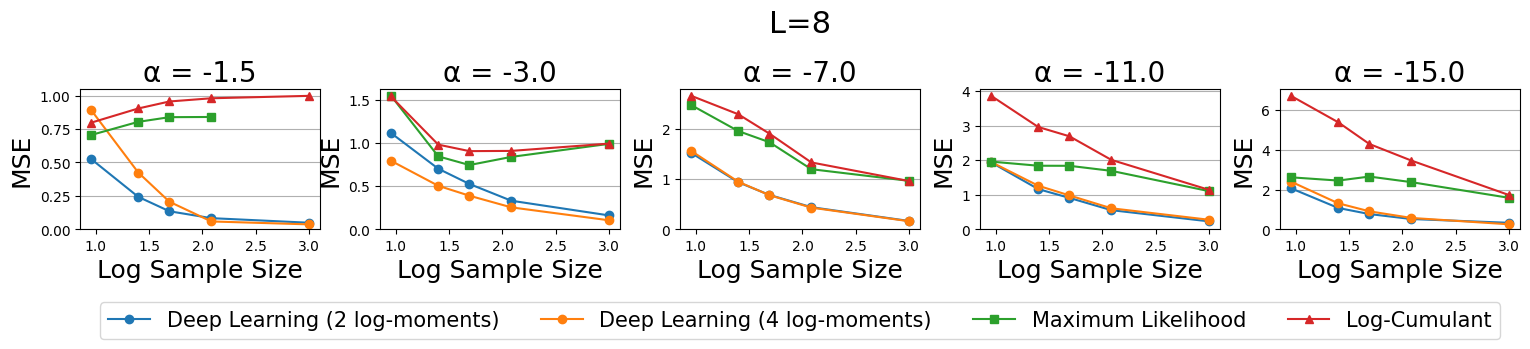

In [73]:
fig = plt.figure(figsize=(18,2))
grid = []
axes = fig.subplots(nrows=1, ncols=5)
for ax in fig.axes:
  grid.append(ax)

fig.suptitle(f'L={L_test}',fontsize=22, y=1.3)
fig.subplots_adjust(left=0.1,bottom=0.2,right=0.9,
                    top=0.9,wspace=0.25,hspace=0.35)

MSE_MAT_DL2_mean = np.nanmean(MSE_MAT_DL2,axis=(2))
MSE_MAT_DL4_mean = np.nanmean(MSE_MAT_DL4,axis=(2))
MSE_MAT_MLE_mean = np.nanmean(MSE_MAT_MLE,axis=(2))
MSE_MAT_CUM_mean = np.nanmean(MSE_MAT_CUM,axis=(2))

xx = np.log10(sample_sizes)
for i in range(len(alpha_test)):
  ax = grid[i]
  ax.plot(xx,MSE_MAT_DL2_mean[:,i],'-o',label=f"Deep Learning (2 log-moments)")
  ax.plot(xx,MSE_MAT_DL4_mean[:,i],'-o',label=f"Deep Learning (4 log-moments)")
  ax.plot(xx,MSE_MAT_MLE_mean[:,i],'-s',label="Maximum Likelihood")
  ax.plot(xx,MSE_MAT_CUM_mean[:,i],'-^',label="Log-Cumulant")
  ax.set_title(f"\u03B1 = {alpha_test[i]}",fontsize=20)
  ax.set_xlabel("Log Sample Size",fontsize=18)
  ax.set_ylabel("MSE",fontsize=18)
  # ax.set_ylim(0,ylim_max)
  ax.set_ylim(0)
  ax.grid(axis = 'y')

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', ncol=4, fontsize=15, bbox_to_anchor=(0.5, -0.4))

plt.show()

In [74]:
A = np.stack((MSE_MAT_DL2_mean.T.flatten(), MSE_MAT_DL4_mean.T.flatten(), \
                MSE_MAT_CUM_mean.T.flatten(), MSE_MAT_MLE_mean.T.flatten()), axis = 1)
print(A)

[[0.52712671 0.89403352 0.79709354 0.70494698]
 [0.24324754 0.42498546 0.90355867 0.80364648]
 [0.13559788 0.20672192 0.95586316 0.83862163]
 [0.08421722 0.05953621 0.97983541 0.84008759]
 [0.0498625  0.03766053 0.99796244        nan]
 [1.11733791 0.79549709 1.54020215 1.54981001]
 [0.70317422 0.50547205 0.98227711 0.84631161]
 [0.5264463  0.39044701 0.90702949 0.74596045]
 [0.33245539 0.25560519 0.90966102 0.84007835]
 [0.16207354 0.10565021 0.99421204 0.99171326]
 [1.53354665 1.57291207 2.67356212 2.48907513]
 [0.94308092 0.95305156 2.30229456 1.9663587 ]
 [0.68970945 0.68434932 1.91544848 1.74340762]
 [0.44493464 0.43568599 1.33946057 1.20408231]
 [0.16858078 0.16335802 0.96663212 0.97084703]
 [1.9398907  1.94873214 3.86075084 1.95854256]
 [1.16410837 1.26136159 2.95673599 1.8386841 ]
 [0.90978077 0.98138183 2.68863391 1.83665106]
 [0.55621662 0.61062989 2.00850467 1.6912949 ]
 [0.2319431  0.27867726 1.14140777 1.104819  ]
 [2.06660608 2.40011401 6.70707252 2.61622288]
 [1.07635716 

In [75]:
dl4_failure = 100 * np.sum(np.isnan(MSE_MAT_DL4))/MSE_MAT_DL4.size
dl2_failure = 100 * np.sum(np.isnan(MSE_MAT_DL2))/MSE_MAT_DL2.size
dmle_failure = 100 * np.sum(np.isnan(MSE_MAT_MLE))/MSE_MAT_MLE.size
dlcum_failure = 100 * np.sum(np.isnan(MSE_MAT_CUM))/MSE_MAT_CUM.size


print(f"DL4: {dl4_failure}")
print(f"DL2: {dl2_failure}")
print(f"MLE: {dmle_failure}")
print(f"LCUM: {dlcum_failure}")

DL4: 7.636
DL2: 4.896
MLE: 47.888
LCUM: 18.356
